Using free and open source tools, provide a set of choropleth visualizations for each of the columns containing dates such that the resulting visualizations (48 states only) tell the story by conveying through color or texture or both the timelines of achievement of each milestone/column in the provided dataset. Missing data is of particular interest in that when a state has never achieved a given milestone, that should be indicated in a stand-out manner such as cross-hatching.  Consider that the publication may be grey-scale.  Provide a solution for that as well.  Provide the titles, labels, and legends necessary for clarification.  File support is given as follows:  SturmCodebook has the explanation.  SturmData is the data CSV.

Some additional notes: 

 

Missing data is of particular interest in that when a state has never achieved a given milestone, that should be indicated in a stand-out manner such as cross-hatching. 

Consider that the publication may be grey-scale.  Provide a solution for that as well. 

Provide the titles, labels, and legends necessary for clarification. 

Cross hatching is not required.  You may use any method to indicate that the state did not ever achieve the milestone, including leaving it blank. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import geopandas as gpd
import folium 


# Load the data
sturm_data = pd.read_csv('SturmData.csv')

# Display
sturm_data.head(6)

,state,fips,icpsr,debtfree,effectivemwpa,earnings,wills,soletrader
0,AL,1,41,1846.0,NaN,1887.0,NaN,NaN
1,AR,5,42,1835.0,1873.0,1873.0,1868.0,1868.0
2,AZ,4,61,1864.0,1871.0,1973.0,NaN,1871.0
3,CA,6,71,1850.0,1872.0,1872.0,1874.0,1872.0
4,CO,8,62,1861.0,1861.0,1861.0,1874.0,1874.0
5,CT,9,1,1845.0,1877.0,1877.0,1809.0,1877.0


In [2]:
# Treat dates greater than 1920 as NaNs
year_cols = ['debtfree', 'effectivemwpa', 'earnings', 'wills', 'soletrader']
for col in year_cols:
    sturm_data[col] = sturm_data[col].apply(lambda x: np.nan if x > 1920 else x)

In [3]:

# Load US states shapefile
us_states = gpd.read_file('https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json')

# Remove Alaska and Hawaii from the shapefile
us_states = us_states[(us_states['name'] != 'Alaska') & (us_states['name'] != 'Hawaii')]

# Display
print(us_states.head())

   id        name                                           geometry
0  AL     Alabama  POLYGON ((-87.35930 35.00118, -85.60667 34.984...
2  AZ     Arizona  POLYGON ((-109.04250 37.00026, -109.04798 31.3...
3  AR    Arkansas  POLYGON ((-94.47384 36.50186, -90.15254 36.496...
4  CA  California  POLYGON ((-123.23326 42.00619, -122.37885 42.0...
5  CO    Colorado  POLYGON ((-107.91973 41.00391, -105.72895 40.9...


In [4]:
# Merge state data with shapefile
merged_data = us_states.merge(
    sturm_data, how='left', left_on='id', right_on='state')

#Dispaly
merged_data.head(5)

,id,name,geometry,state,fips,icpsr,debtfree,effectivemwpa,earnings,wills,soletrader
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",AL,1,41,1846.0,NaN,1887.0,NaN,NaN
1,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",AZ,4,61,1864.0,1871.0,NaN,NaN,1871.0
2,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",AR,5,42,1835.0,1873.0,1873.0,1868.0,1868.0
3,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",CA,6,71,1850.0,1872.0,1872.0,1874.0,1872.0
4,CO,Colorado,"POLYGON ((-107.91973 41.00391, -105.72895 40.9...",CO,8,62,1861.0,1861.0,1861.0,1874.0,1874.0


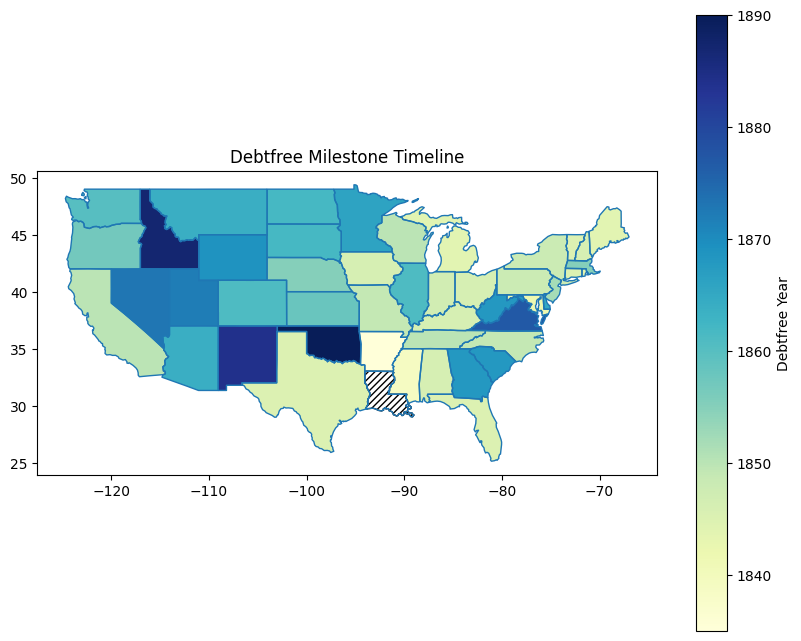

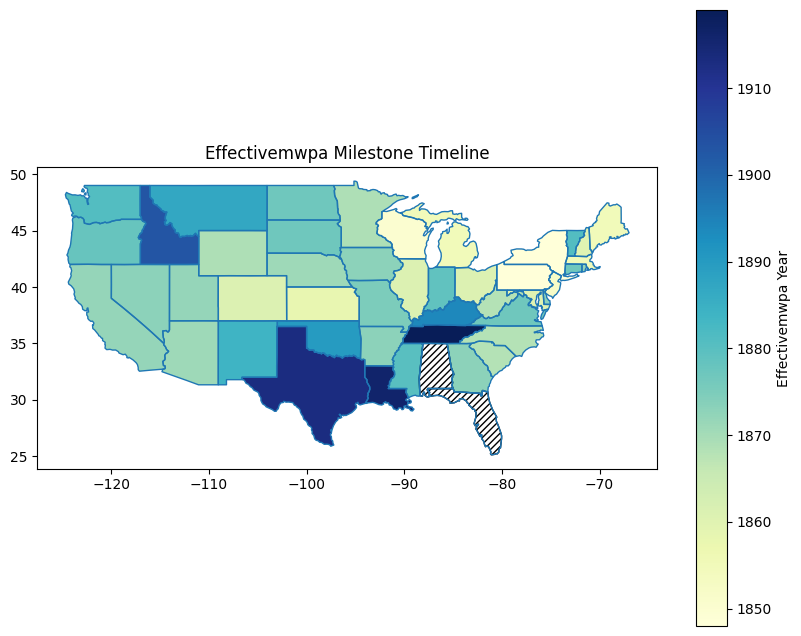

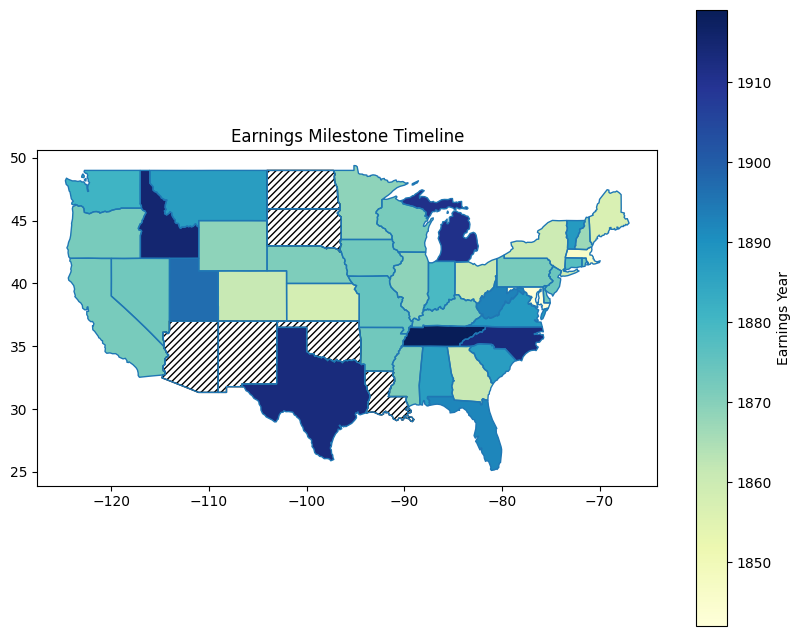

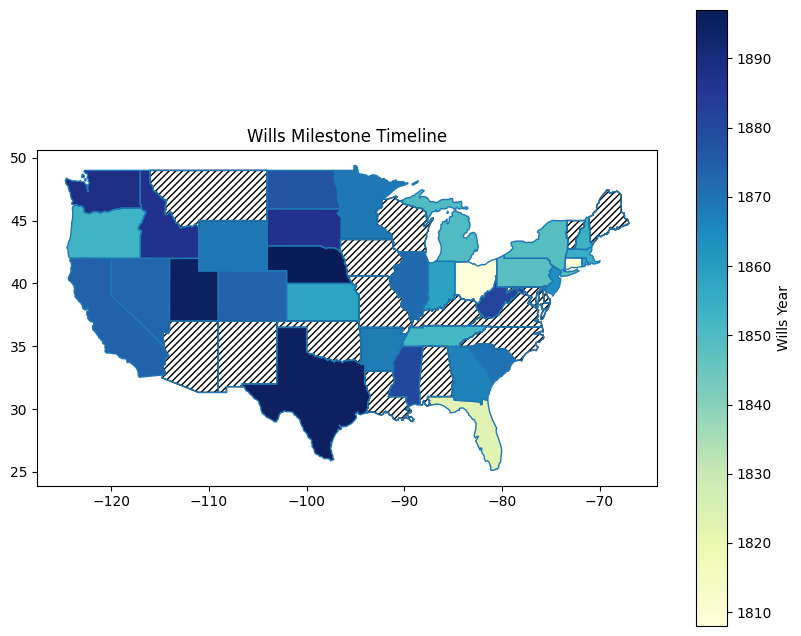

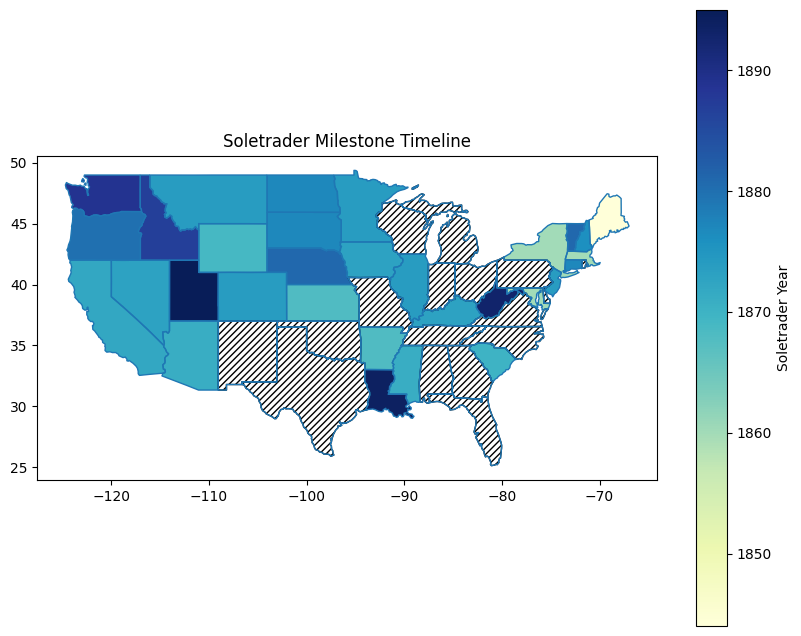

In [5]:
# Define hatch pattern for missing data
hatch_pattern = '/////'
# Create choropleth maps
for col in year_cols:
    plt.figure(figsize=(10, 8))
    plt.title(f'{col.capitalize()} Milestone Timeline')
    ax = plt.gca()
    merged_data.boundary.plot(ax=ax, linewidth=1)
    merged_data.plot(column=col, cmap='YlGnBu', linewidth=0.8,
                     ax=ax, legend=True, legend_kwds={'label': f'{col.capitalize()} Year'})
    # Apply cross-hatching for NaNs
    merged_data[merged_data[col].isna()].plot(
        ax=ax, color='none', edgecolor='black', hatch=hatch_pattern)

    plt.show()

In [6]:
# Create Folium maps and export to HTML
threshold_scale = [1800, 1820, 1840, 1860, 1880, 1900, 1920]
# Create Folium maps and export to HTML
for col in year_cols:
    m = folium.Map(location=[48, -102], zoom_start=3)
    folium.Choropleth(
        geo_data=us_states,
        data=sturm_data,
        columns=['state', col],
        key_on='feature.properties.id',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f'{col.capitalize()} Milestone Timeline',
        highlight=True,
        threshold_scale=threshold_scale,
        nan_fill_color='white',  # EnsureSs NaNs are white to allow hatching visibility
        nan_fill_opacity=0.6
    ).add_to(m)
    # Add cross-hatching for NaNs using  Folium's GeoJson to add an overlay for states with missing data, styled with dashed lines to simulate cross-hatching.
    folium.GeoJson(
        us_states[us_states['id'].isin(sturm_data[sturm_data[col].isna()]['state'])],
        style_function=lambda x: {'fillColor': 'none', 'color': 'black',
                                  'weight': 1, 'fillOpacity': 0.5, 'dashArray': '5, 5'}
    ).add_to(m)
    m.save(f'{col}_milestone_map.html')